In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from utils import *
from models import *
from tqdm import tqdm

import matplotlib.pyplot as plt

from ArrayModel import *

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
m = 8
d = 3
t = 200
snr = 20
n = 10000
mc_range = 3

lamda = 0.2
radius = 0.1

array = UCA(m=m, lamda=lamda)
array.build_sensor_positions(radius=radius)
array.build_array_manifold()
array.build_transform_matrices()

torch.manual_seed(30)
mc_coef = torch.zeros(5, dtype=torch.complex64)
mc_coef[:mc_range] = torch.rand(mc_range, dtype=torch.complex64)
C = build_symmetric_circulant_toeplitz(mc_coef)
C = C - torch.diag(torch.diag(C)) + torch.eye(m, dtype=torch.complex64)
torch.manual_seed(torch.seed())

loss_cpu = RMSPE(d, 'cpu')
loss_cuda = RMSPE(d, 'cuda')

path = 'saved_models/'

SNRs = [-10, -5, 0, 5, 10, 15, 20]
titles = []
methods = []
mean_mse = {}

In [3]:
methods.append('RARE')
titles.append('RARE')
mean_mse['RARE'] = []
rare = RARE(d, mc_range, array, -torch.pi/2, torch.pi/2, 360)

for snr in SNRs:

    observations, angles = generate_data(10000, t, d, snr, snr, array,  False, C=C)

    results_rare = []
    for i in range(observations.shape[0]):
        theta_est, _= rare.estimate(observations[i].T)
        results_rare.append(theta_est)
    results_rare = torch.stack(results_rare, dim=0)
    
    mse_rare = loss_cpu(results_rare, angles)
    mean_mse['RARE'].append(mse_rare)

In [4]:
methods.append("DA-MUSIC")
titles.append("DA-MUSIC")
mean_mse["DA-MUSIC"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, False, C=C)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music = DA_MUSIC(m, d, array, dev)
    mean_mse['DA-MUSIC'].append(test(da_music, test_loader, path+'da_music_'+str(snr)+'dB_uca.pth', loss_cuda, dev))

In [5]:
methods.append("DA-MUSIC v2")
titles.append("Proposed Modified DA-MUSIC")    
mean_mse["DA-MUSIC v2"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, False, C=C)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music_v2 = DA_MUSIC_v2(m, d, array, dev)
    mean_mse['DA-MUSIC v2'].append(test(da_music_v2, test_loader, path+'da_music_v2_'+str(snr)+'dB_uca.pth', loss_cuda, dev))

In [6]:
methods.append("RNN")
titles.append("Proposed Modified DD Model")
mean_mse["RNN"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, False, C=C)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    rnn = RNN(m, d, dev)
    mean_mse['RNN'].append(test(rnn, test_loader, path+'rnn_'+str(snr)+'dB_uca.pth', loss_cuda, dev))

In [7]:
torch.save(mean_mse, 'mean_mse.pth')
mean_mse = torch.load('mean_mse.pth')

/tmp/ipykernel_32870/4234131840.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean_mse = torch.load('mean_mse.pth')


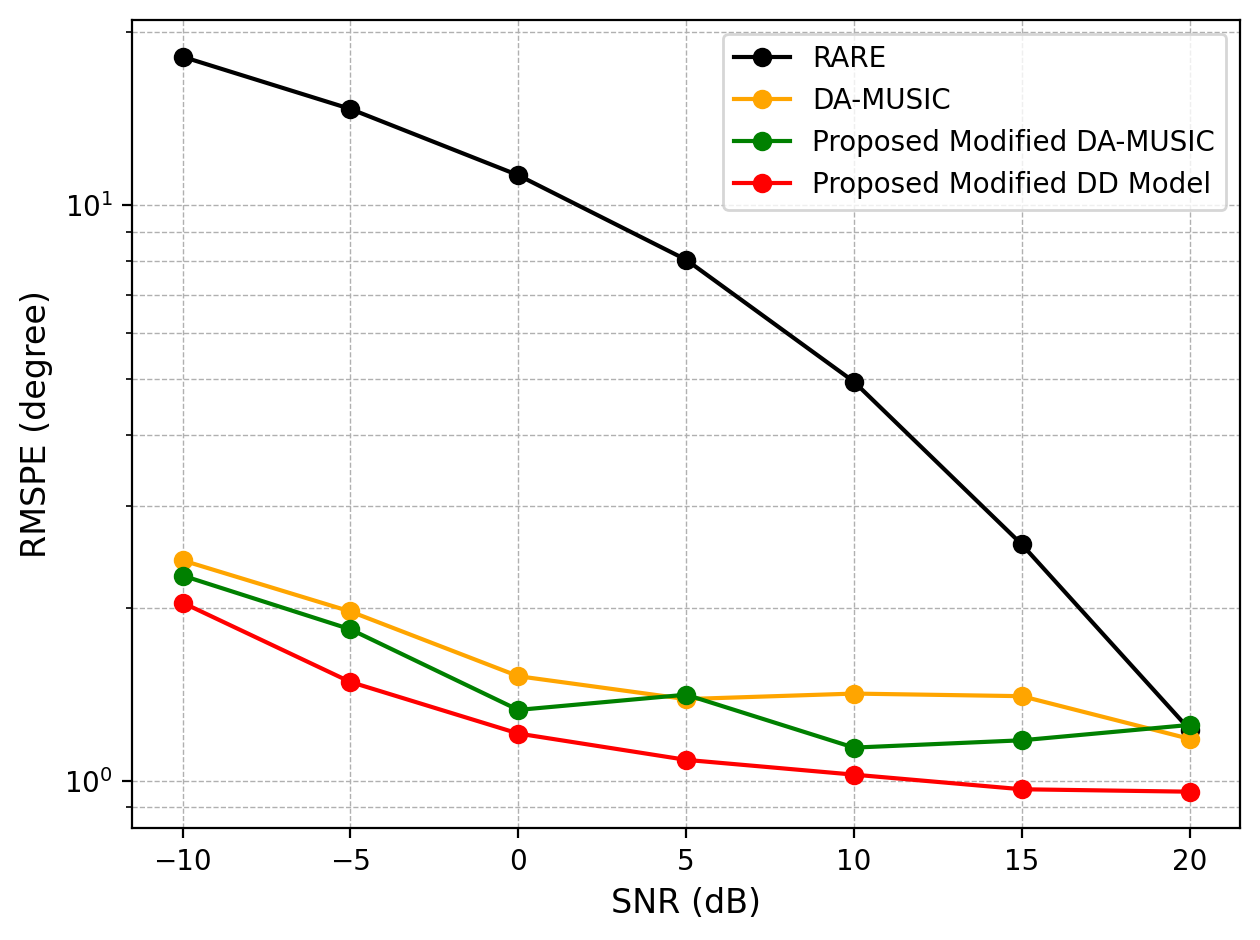

In [12]:
# plt.figure(figsize=(10, 6))
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray']
colors = ['black', 'orange', 'green', 'red']

plt.rcParams['figure.dpi'] = 200
for i, method in enumerate(methods):
    plt.plot(SNRs, [x/torch.pi*180 for x in mean_mse[method]], marker='o', label=titles[i], color=colors[i])

plt.yscale("log")
# plt.title("{} scenarios".format(n), fontsize=14)
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("RMSPE (degree)", fontsize=12)
plt.xticks(SNRs)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.tight_layout()
plt.show()